# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape, Activation
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.activations import softmax
from keras.objectives import binary_crossentropy as bce
from keras.objectives import mean_squared_error as mse


%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# Model

In [108]:
def sampling(logits_y):
    U = K.random_uniform(K.shape(logits_y), 0, 1)
    y = logits_y - K.log(-K.log(U + 1e-20) + 1e-20) # logits + gumbel noise
    y = softmax(K.reshape(y, (-1, N, M)) / tau)
    y = K.reshape(y, (-1, N*M))
    return y

def gumbel_loss(x, x_hat):
    # calc KL divergence
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    # 
    x = K.reshape(x, (1,-1))
    x_hat = K.reshape(x_hat, (1,-1))
#     elbo = DATA_DIM * bce(x, x_hat) - KL
    elbo = DATA_DIM * mse(x, x_hat) - KL
    return elbo

In [70]:
batch_size = 100
DATA_DIM = 784
M = 15
N = 10
nb_epochs = 30 #100
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.5

In [71]:

tau = K.variable(5.0, name="temperature")
# tau = K.variable(2.5, name="temperature")

# x = Input(batch_shape=(batch_size, DATA_DIM))
x = Input(shape=( 784, ))
h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
logits_y = Dense(M*N, activation='relu', name="logits_y")(h)

# z = Lambda(sampling, output_shape=(M*N,))(logits_y)

z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z)
generator = Sequential()
generator.add(Dense(256, activation='relu', input_shape=(N*M, )))
generator.add(Dense(512, activation='relu'))
generator.add(Dense(DATA_DIM, activation='sigmoid'))
x_hat = generator(z)

# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))

vae = Model(x, x_hat)
vae_test = Model(x, [x_hat, logits_y, z_])

vae.compile(optimizer='adam', loss=gumbel_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
logits_y (Dense)             (None, 150)               38550     
_________________________________________________________________
lambda_17 (Lambda)           (None, 150)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 784)               572432    
Total params: 1,144,230
Trainable params: 1,144,230
Non-trainable params: 0
_________________________________________________________________


# Model 2

In [128]:
batch_size = 64
IMAGE_DIM = (28,28)
INPUT_DIM = (28,28,1)
DATA_DIM = 784 # MNIST: 28x28x1
M = 7 #10
N = 42 #30
nb_epochs = 50 #100
epsilon_std = 0.01

anneal_rate = 0.0003
max_temperature = 5.0
min_temperature = 0.5

tau = K.variable(max_temp, name="temperature")
ACTIV = "relu"


# ======= DEFINE MODEL
x = Input(shape=INPUT_DIM)
h = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation=ACTIV)(x)
h = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=ACTIV)(h)
h = Flatten()(h)

logits_y = Dense(M*N, activation=None)(h)

z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z)

z_dec = Reshape( (M,M,-1), input_shape=(N*M,) )
z_h = Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding="same", activation=ACTIV)
z_h2 = Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding="same", activation=ACTIV)
x_hat = Conv2D(filters=1, kernel_size=4, strides=1, padding="same", activation="sigmoid")
# x_hat = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding="same", activation="sigmoid")

decoded_x = x_hat(z_h2(z_h(z_dec( z ))))

decode_input = Input( shape=(M*N,) )
decoder = x_hat(z_h2(z_h(z_dec( decode_input ))))
generator = Model(decode_input, decoder)


vae_test = Model(x, [decoded_x, logits_y, z_])
vae = Model(x, decoded_x)

# reconstruction loss
def recon_loss(x, x_hat):
    return DATA_DIM * mse(x, x_hat)

# KL divergence
def kl_div(x, x_hat):
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    return KL


vae.compile(optimizer='adam', 
            loss=gumbel_loss,
            metrics=[recon_loss, kl_div])
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 32)        544       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 7, 64)          32832     
_________________________________________________________________
flatten_19 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 294)               922278    
_________________________________________________________________
lambda_19 (Lambda)           (None, 294)               0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 7, 7, 6)           0         
__________

# Model 3

In [149]:
batch_size = 64
IMAGE_DIM = (64,64,3)
INPUT_DIM = (64,64,3)
DATA_DIM = 12288 # MNIST: 28x28x1
M = 6
N = 10
nb_epochs = 50 #100
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.5

In [150]:
tau = K.variable(5.0, name="temperature")
ACTIV = "relu"

# x = Input(batch_shape=(batch_size, data_dim ))
x = Input(shape=INPUT_DIM)
# h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
h = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation=ACTIV)(x)
h = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=ACTIV)(h)
# h = Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation=ACTIV)(h)
h = Flatten()(h)

logits_y = Dense(M*N, activation=None)(h)

# z = Lambda(sampling, output_shape=(M*N,))(logits_y)
z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z)

# z = Reshape((1,1,N*M))(z)
# z = Conv2DTranspose(filters=32, kernel_size=6, strides=4, padding="same")(z)
# z = Conv2DTranspose(filters=32, kernel_size=3, strides=4, padding="same")(z)
# z = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same")(z)
# x_hat = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same")(z)

z_1 = Reshape((1,1,N*M))
z_2 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_3 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_4 = Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_5 = Conv2DTranspose(filters=16, kernel_size=4, strides=4, padding="same", activation=ACTIV)
x_hat = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", activation="sigmoid")

decoded_x = x_hat(z_5(z_4(z_3(z_2(z_1( z ))))))


# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))

decode_input = Input( shape=(M*N,) )
decoder = x_hat(z_5(z_4(z_3(z_2(z_1( decode_input ))))))
generator = Model(decode_input, decoder)

vae_test = Model(x, [decoded_x, logits_y, z_])
vae = Model(x, decoded_x)
vae.compile(optimizer='adam', loss=gumbel_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        32832     
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 60)                983100    
_________________________________________________________________
lambda_5 (Lambda)            (None, 60)                0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 1, 60)          0         
__________

# Train

## import data

In [129]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# vectorize
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# give extra third dimensioin
x_train = x_train.reshape( (len(x_train),28,28,1  ) )
x_test = x_test.reshape( (len(x_test),28,28,1  ) )

# reduce data set size
x_train = x_train[:10000]
x_test = x_test[:2000]

print(x_train.shape, x_test.shape)

(10000, 28, 28, 1) (2000, 28, 28, 1)


## race car data

In [151]:
import os
data_dir = "world_models_data"
data1 = "small_obs_data_car_racing_1.npy"
np_dat = np.load(os.path.join(data_dir, data1))

In [152]:
x_train = np_dat[:8000]
x_test = np_dat[8000:]
print(x_train.shape, x_test.shape)

(8000, 64, 64, 3) (2000, 64, 64, 3)


## Training

In [130]:
# Callback for keras training, to update temperature param after each epoch
class UpdateTemperatureCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.taus = []

    def on_epoch_end(self, epoch, logs=None):
        K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * epoch), min_temperature]))
#         K.set_value(tau, get_temp(max_temperature, min_temperature, nb_epochs, epoch))
        self.taus.append( K.get_value(tau) )

        
def get_temp(max_tau, min_tau, nb_points, point):
    # TODO: wasteful to call linspace everytime, but just convenient during development (because nb_epochs changes)
    return np.linspace(max_tau, min_tau, nb_points)[point]


# Will contain list of tau values used during training
tau_callback = UpdateTemperatureCallback()

train_info = vae.fit(x_train, x_train, 
    shuffle=True, 
    epochs=nb_epochs, 
    batch_size=batch_size,
    validation_data=(x_test, x_test),
    callbacks=[tau_callback])

Train on 10000 samples, validate on 2000 samples
Epoch 1/50
10000/10000 [==============================] - 3s 317us/step - loss: 16.7988 - recon_loss: 92.4780 - kl_div: 75.6793 - val_loss: -15.4723 - val_recon_loss: 66.2559 - val_kl_div: 81.7282
Epoch 2/50
10000/10000 [==============================] - 2s 184us/step - loss: -21.3234 - recon_loss: 60.4048 - kl_div: 81.7282 - val_loss: -28.1447 - val_recon_loss: 53.5835 - val_kl_div: 81.7282
Epoch 3/50
10000/10000 [==============================] - 2s 189us/step - loss: -27.8979 - recon_loss: 53.7848 - kl_div: 81.6826 - val_loss: -32.0303 - val_recon_loss: 49.6294 - val_kl_div: 81.6597
Epoch 4/50
10000/10000 [==============================] - 2s 219us/step - loss: -29.9738 - recon_loss: 51.6654 - kl_div: 81.6391 - val_loss: -33.8673 - val_recon_loss: 47.6977 - val_kl_div: 81.5650
Epoch 5/50
10000/10000 [==============================] - 2s 229us/step - loss: -32.8878 - recon_loss: 48.6250 - kl_div: 81.5128 - val_loss: -36.4327 - val_reco

10000/10000 [==============================] - 2s 174us/step - loss: -76.9911 - recon_loss: 4.1896 - kl_div: 81.1807 - val_loss: -76.0210 - val_recon_loss: 4.7801 - val_kl_div: 80.8012
Epoch 43/50
10000/10000 [==============================] - 2s 173us/step - loss: -77.0783 - recon_loss: 4.1166 - kl_div: 81.1948 - val_loss: -76.1542 - val_recon_loss: 4.6761 - val_kl_div: 80.8303
Epoch 44/50
10000/10000 [==============================] - 2s 173us/step - loss: -77.1004 - recon_loss: 4.0997 - kl_div: 81.2002 - val_loss: -76.2634 - val_recon_loss: 4.5410 - val_kl_div: 80.8044
Epoch 45/50
10000/10000 [==============================] - 2s 174us/step - loss: -77.1252 - recon_loss: 4.0818 - kl_div: 81.2070 - val_loss: -76.1392 - val_recon_loss: 4.6675 - val_kl_div: 80.8067
Epoch 46/50
10000/10000 [==============================] - 2s 174us/step - loss: -77.1430 - recon_loss: 4.0653 - kl_div: 81.2083 - val_loss: -76.3342 - val_recon_loss: 4.4967 - val_kl_div: 80.8309
Epoch 47/50
10000/10000 [==

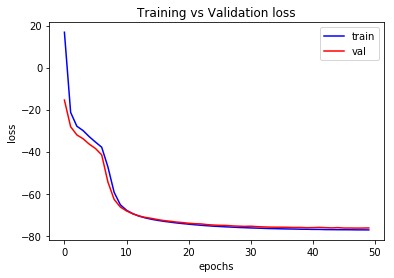

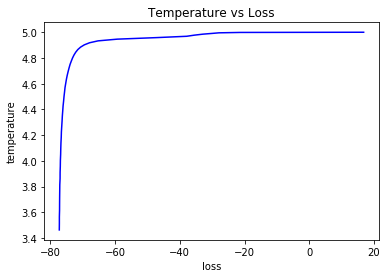

In [131]:
# plot train hist..
np_loss = np.asarray(train_info.history["loss"])
np_val_loss = np.asarray(train_info.history["val_loss"])

figure(1)
t = range(nb_epochs)
plt.plot(t, np_loss, 'b-', label="train") 
plt.plot(t, np_val_loss, 'r-', label="val")
plt.title("Training vs Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

# t = np.flip( tau_callback.taus, axis=0 )
t = tau_callback.taus
plt.plot(np_loss, t, 'b-', label="train") 
plt.title("Temperature vs Loss")
plt.xlabel("loss")
plt.ylabel("temperature")
plt.show()




## Save model weights

In [101]:
# vae.save_weights('model3_vae_weights.h5')

# Visualize results

In [132]:
argmax_y = K.max(K.reshape(logits_y, (-1, N, M)), axis=-1, keepdims=True)
argmax_y = K.equal(K.reshape(logits_y, (-1, N, M)), argmax_y)
# encoder = K.function([x], [argmax_y, x_hat])
encoder = K.function([x], [argmax_y, decoded_x])


(<matplotlib.image.AxesImage at 0x27868c87358>, (-0.5, 27.5, 27.5, -0.5))

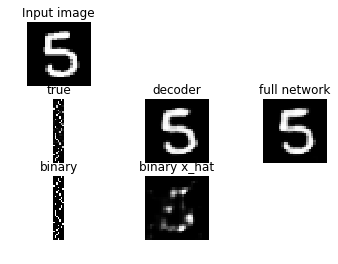

In [133]:
# test_idx, try: from 160-180
test_idx = 165
_batch = 300
code, x_hat_test = encoder([x_test[:_batch]])

_x_hat, _logits, _z = vae_test.predict(x_test[:_batch])

subplot(331)
title("Input image")
# imshow(x_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
# imshow(x_test[test_idx].reshape(64, 64, 3), cmap='gray'), axis('off')
imshow(x_test[test_idx].reshape(IMAGE_DIM), cmap='gray'), axis('off')

subplot(334)
title("true")
imshow(_z[test_idx].reshape(N, M), cmap='gray'), axis('off')

subplot(335)
title("decoder")
img_true = generator.predict(np.reshape(_z[test_idx], (1,-1)) )
# imshow(img_true.reshape(28, 28), cmap='gray'), axis('off')
# imshow(img_true.reshape(64, 64, 3), cmap='gray'), axis('off')
imshow(img_true.reshape(IMAGE_DIM), cmap='gray'), axis('off')

subplot(336)
title("full network")
# imshow(x_hat_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
# imshow(x_hat_test[test_idx].reshape(64, 64, 3), cmap='gray'), axis('off')
imshow(x_hat_test[test_idx].reshape(IMAGE_DIM), cmap='gray'), axis('off')


# imshow(x_hat_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
# imshow(x_hat_test[test_idx].reshape(64, 64, 3), cmap='gray'), axis('off')

subplot(337)
title("binary")
imshow(code[test_idx].reshape(N, M), cmap='gray'), axis('off')

subplot(338)
title("binary x_hat")
img_binary = generator.predict(np.reshape(code[test_idx], (1,-1)) )
# imshow(img_binary.reshape(28, 28), cmap='gray'), axis('off')
# imshow(img_binary.reshape(64, 64, 3), cmap='gray'), axis('off')
imshow(img_binary.reshape(IMAGE_DIM), cmap='gray'), axis('off')




## More visualizations

Top: Input images
Bottom: Reconstructions


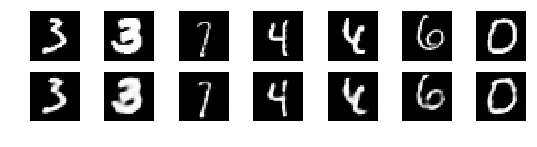

In [134]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 2), dpi=80, facecolor='w', edgecolor='k')

from matplotlib.pyplot import subplots_adjust
subplots_adjust(wspace = 0.5, hspace=0)

diverse_obs = [230, 200, 175, 170, 160, 100, 10]

# ROW-WISE
# rows = len(diverse_obs)
# cols = 2
# next_idx = 1

# for i, obs in enumerate(diverse_obs):
#     subplot( rows, cols, next_idx )
#     title("Input image")
#     # imshow(x_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
#     imshow(x_test[obs].reshape(64, 64, 3), cmap='gray'), axis('off')
    
#     next_idx += 1
    
#     subplot( rows, cols, next_idx )
#     title("decoder")
#     img_true = generator.predict(np.reshape(_z[obs], (1,-1)) )
#     # imshow(img_true.reshape(28, 28), cmap='gray'), axis('off')
#     imshow(img_true.reshape(64, 64, 3), cmap='gray'), axis('off')
    
#     next_idx += 1

# COLUMN WISE
rows = 2
cols = len(diverse_obs)

print("Top: Input images\nBottom: Reconstructions")
for i, obs in enumerate(diverse_obs):
    i += 1
    subplot( rows, cols, i )
    # imshow(x_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
#     imshow(x_test[obs].reshape(64, 64, 3), cmap='gray'), axis('off')
    imshow(x_test[obs].reshape(IMAGE_DIM), cmap='gray'), axis('off')
    
    subplot( rows, cols, i+cols )
    img_true = generator.predict(np.reshape(_z[obs], (1,-1)) )
    # imshow(img_true.reshape(28, 28), cmap='gray'), axis('off')
#     imshow(img_true.reshape(64, 64, 3), cmap='gray'), axis('off')
    imshow(img_true.reshape(IMAGE_DIM), cmap='gray'), axis('off')




# Create sample 1.0

In [84]:
%matplotlib inline
from ipywidgets import interactive
from ipywidgets import widgets
from IPython.display import display

In [86]:
# N = 10
# M = 5

img_code = np.zeros( (N,M) )

def f(*args,**kwargs):
#     print(kwargs)
    for i, key in enumerate(kwargs):
#         print( kwargs[key] )
        zero_row = np.zeros((1,M))
        zero_row[0, kwargs[key] ] = 1
        img_code[i] = zero_row
    
    plt.subplot(121)
    plt.imshow(img_code, cmap="gray")
    
    plt.subplot(122)
    img_binary = generator.predict(np.reshape(img_code, (1,-1)) )
#     plt.imshow(img_binary.reshape(28, 28), cmap='gray')
#     plt.imshow(img_binary.reshape(64, 64, 3), cmap='gray')
    plt.imshow(img_binary.reshape(IMAGE_DIM), cmap='gray')
    plt.axis('off')


kw_dict = {}
for n in range(N):
    kw_dict["z"+str(n)] = widgets.IntSlider(description="z"+str(n), min=0, max=(M-1), value=int(M/2), continuous_update=False)

interactive_plot = interactive(f, **kw_dict)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=3, continuous_update=False, description='z17', max=6), IntSlider(value=3…